In [1]:
import gsw
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import xarray as xr

from acspype.utils.ooi import download_and_load_goldcopy, reformat_ooi_optaa, get_ooi_optaa_cal
import acspype.processing as acsproc
import acspype.qaqc as acsqaqc
from acspype.tscor import ACSTSCor

## Step 0: Accessing Example Data

In this example, we will be using ACS data from the OOI Oregon Shelf Coastal Surface Piercing Profiler (CE02SHSP). 

#### Download and Select OOI Data
If you inspect the data before it is reformatted, you'll find that it has the dimensions of `obs` and `wavelength`. These two dimensions are not compatible with *acspype* and do not provide any meaningful information. `obs` is simply and iterative identify for a file. `wavelength`, in this instance, is also an iterative identifier and not actually representative of the actual wavelength. This is particularly confusing because variables associated with absorption will have different wavelengths compared to those associated with attenuation. 

Since all OOI ACS assets are (currently) immobile and files ***SHOULD*** only contain data from one ACS, the reformatted dataset reassigns latitude, longitude, and deployment as coordinates rather than variables. If continuing to use Xarray, the acspype functions should handle these extra dimensions, but this example will whittle the dataset down to the coordinates of `time`, `a_wavelength`, and `c_wavelength` for simplicity.

In [2]:
acs_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/ooigoldcopy/public/CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered/deployment0013_CE02SHSP-SP001-04-OPTAAJ000-recovered_cspp-optaa_dj_cspp_instrument_recovered_20190624T165543.774000-20190627T023924.583000.nc'
acs = download_and_load_goldcopy(acs_url)
acs = reformat_ooi_optaa(acs)
acs = acs.sel(latitude = float(acs.latitude), longitude = float(acs.longitude), deployment = int(acs.deployment))

The `reformat_ooi_optaa` function renames `optical_absorption` and `beam_attenuation` to `a_m_discontinuity` and `c_m_discontinuity`, respectively. These variables are not corrected for the discontinuity step that is observed in all ACS datasets. In this example, we will recalculate these variables from the raw data, so they are removed in the cell below.

In [3]:
acs = acs.drop_vars(['a_m_discontinuity','c_m_discontinuity'])

#### Download ACS Device Calibration Information

In [4]:
acs_dev = get_ooi_optaa_cal(acs)

#### Quick Verification of Data and Device File
The device file is a file that is unique to each ACS. For OOI datasets, one way to verify that you have the correct device file information is to verify that the wavelength values match between the file and the calibration information. In some rare cases, two calibration files for the same instrument may have the same wavelengths, so it is important to use the calibration information that happens before the data collection and is closest to the first timestamp in the dataset. The `get_ooi_optaa_cal` function does this automatically.

In [5]:
assert np.all(acs_dev.a_wavelength == acs.a_wavelength)

## Step 1: Reprocess Data

In [6]:
acs['sea_water_absolute_salinity'] = gsw.SA_from_SP(acs.sea_water_practical_salinity, acs.sea_water_pressure, acs.longitude, acs.latitude)
acs['sea_water_conservative_temperature'] = gsw.CT_from_t(acs.sea_water_absolute_salinity, acs.sea_water_temperature, acs.sea_water_pressure)

In [7]:
acs['internal_temperature'] = acsproc.compute_internal_temperature(acs.raw_internal_temperature)
acs['external_temperature'] = acsproc.compute_external_temperature(acs.raw_external_temperature)

In [8]:
acs['a_uncorrected'] = acsproc.compute_uncorrected(acs.a_signal, acs.a_reference, acs_dev.path_length)
acs['c_uncorrected'] = acsproc.compute_uncorrected(acs.c_signal, acs.c_reference, acs_dev.path_length)

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\xarray\computation\apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [9]:
acs['a_m_discontinuity'] = acsproc.compute_measured(acs.a_uncorrected, acs.internal_temperature, acs_dev.a_offset, acs_dev.func_a_delta_t)
acs['c_m_discontinuity'] = acsproc.compute_measured(acs.c_uncorrected, acs.internal_temperature, acs_dev.c_offset, acs_dev.func_c_delta_t)

In [10]:
discontinuity_index = acsproc.find_discontinuity_index(acs.a_wavelength, acs.c_wavelength)
acs['a_m'], acs['a_discontinuity_offset'] = acsproc.discontinuity_correction(acs.a_m_discontinuity,discontinuity_index,'a_wavelength')
acs['c_m'], acs['c_discontinuity_offset'] = acsproc.discontinuity_correction(acs.c_m_discontinuity,discontinuity_index,'c_wavelength')

In [11]:
tcal = acs_dev.tcal
tscor = ACSTSCor().to_xarray()

psi_t = tscor.psi_t.sel(wavelength=acs.a_wavelength)
psi_s_a = tscor.psi_s_a.sel(wavelength=acs.a_wavelength)
acs['a_mts'] = acsproc.ts_correction(acs.a_m, acs.sea_water_conservative_temperature,acs.sea_water_absolute_salinity, psi_t, psi_s_a, tcal)

psi_t = tscor.psi_t.sel(wavelength=acs.c_wavelength)
psi_s_c = tscor.psi_s_c.sel(wavelength=acs.c_wavelength)
acs['c_mts'] = acsproc.ts_correction(acs.c_m, acs.sea_water_conservative_temperature,acs.sea_water_absolute_salinity, psi_t, psi_s_c, tcal)

In [12]:
acs['a_mts'] = acsproc.zero_shift_correction(acs.a_mts)
acs['c_mts'] = acsproc.zero_shift_correction(acs.c_mts)

In [13]:
acs = acsproc.interpolate_common_wavelengths(acs, 'a_wavelength','c_wavelength')

C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\scipy\interpolate\_interpolate.py:482: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\Ian\phd\projects\acspype\.venv\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [14]:
ref_wvl = acsproc.estimate_reference_wavelength(acs.a_mts, 'wavelength')
ref_wvl = 745

In [15]:
reference_a = acs.a_mts.sel(wavelength = ref_wvl, method = 'nearest')
acs['a_mts_baseline'] = acsproc.baseline_scattering_correction(acs.a_mts, reference_a)

In [16]:
acs['a_mts_fixed'] = acsproc.fixed_scattering_correction(acs.a_mts, acs.c_mts)

In [17]:
reference_a = acs.a_mts.sel(wavelength = ref_wvl, method = 'nearest')
reference_c = acs.c_mts.sel(wavelength = ref_wvl, method = 'nearest')

acs['a_mts_proportional'] = acsproc.proportional_scattering_correction(acs.a_mts, acs.c_mts, reference_a, reference_c)

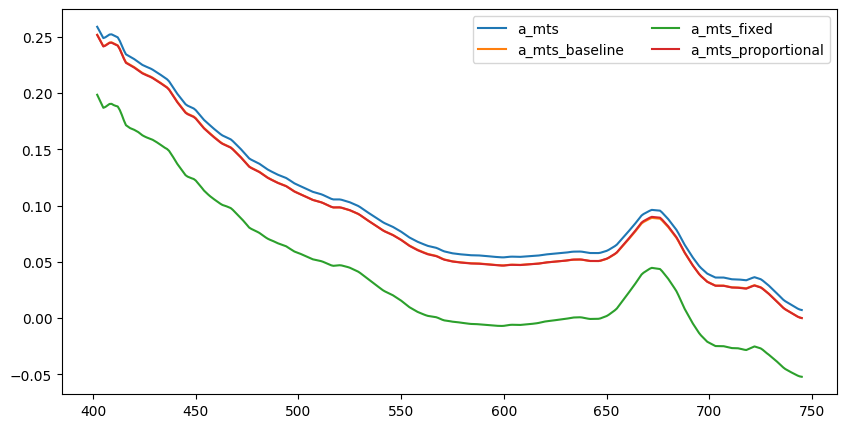

In [18]:
spectrum = acs.sel(time = acs.time.values[-1000])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(spectrum.wavelength, spectrum.a_mts, label='a_mts')
ax.plot(spectrum.wavelength, spectrum.a_mts_baseline, label = 'a_mts_baseline')
ax.plot(spectrum.wavelength, spectrum.a_mts_fixed, label = 'a_mts_fixed')
ax.plot(spectrum.wavelength, spectrum.a_mts_proportional, label = 'a_mts_proportional')
ax.legend(loc = 'upper right', ncols = 2)

## QAQC

In [20]:
acs['flag_elapsed_time'] = acsqaqc.elapsed_time_test(acs.elapsed_time)